In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from random import random

import colorsys
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib
from numpy import inf

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"

In [3]:
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map

In [4]:
norm_min = 0
norm_max = np.max(np.nan_to_num(maps['Y_pos']))
norm_max = 1#0.1#0.15
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][z,:,:].T)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
vol = np.asarray(slices)
print(vol.shape)

(49, 128, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

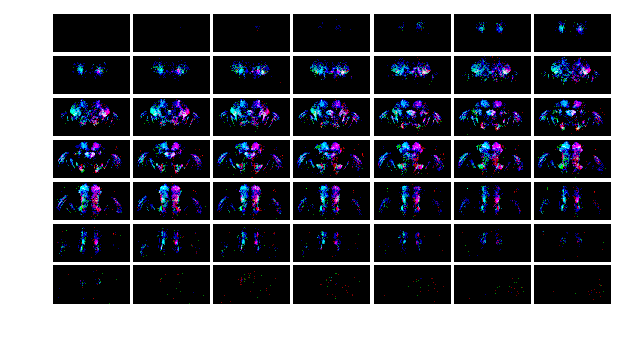

In [87]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(slices[i][:,:,:]*20);
    grid[i].axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [5]:
####################
### MAKE HSV VOL ###
####################

vol_flat = np.reshape(vol, (-1,3))
vol_flat = np.clip(vol_flat,0,1) # there are some negative corrs. remove these.
hsv_vol = []
to_delete = []
to_keep = []
for i in range(vol_flat.shape[0]):
    if np.sum(vol_flat[i]) != 0: # exclude black pixels (0,0,0)
        hsv_vol.append(colorsys.rgb_to_hsv(*vol_flat[i]))
        to_keep.append(i)
    else:
        to_delete.append(i)
hsv_vol = np.asarray(hsv_vol)

In [50]:
len(to_delete)+len(to_keep)

1605632

In [180]:
hsv_vol.shape

(179994, 3)

In [181]:
vol_flat.shape

(1605632, 3)

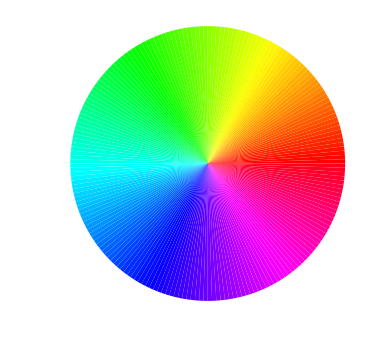

In [10]:
cm = matplotlib.cm.get_cmap('hsv')

patches = []
values = []

ntheta = 200; dtheta = 360/ntheta;
nradius = 1; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta)
colors = [int(i) for i in colors]

saturations = np.linspace(0,.99,nradius)

for j, nr in enumerate(range(nradius,0,-1)):  # See!  Outside to Inside
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
    
        rgb = cm(colors[nt])
        hsv = list(colorsys.rgb_to_hsv(*rgb[0:3]))
        hsv[1] = hsv[1]-saturations[j]
        rgb = colorsys.hsv_to_rgb(*hsv)
        
        values.append(tuple(np.clip(rgb,0,1)))
        wedge = mpatches.Wedge(0,end_r, start_t, end_t)
        patches.append(wedge)
        
collection = PatchCollection(patches,linewidth=0.0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

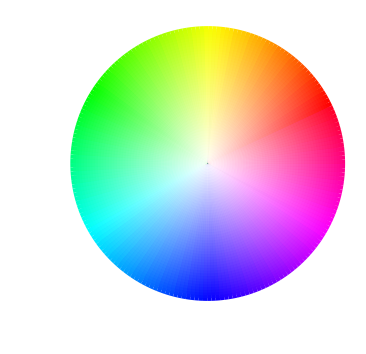

In [20]:
cm = matplotlib.cm.get_cmap('hsv')

patches = []
values = []

rotation = 25

ntheta = 200; dtheta = 360/ntheta;
nradius = 50; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta+1)
colors = [int(i) for i in colors]

saturations = np.linspace(0,.99,nradius)

for j, nr in enumerate(range(nradius,0,-1)):  # See!  Outside to Inside
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
    
        rgb = cm(colors[nt])
        hsv = list(colorsys.rgb_to_hsv(*rgb[0:3]))
        hsv[1] = hsv[1]-saturations[j]
        rgb = colorsys.hsv_to_rgb(*hsv)
        
        values.append(tuple(np.clip(rgb,0,1)))
        wedge = mpatches.Wedge(0,end_r, start_t+rotation, end_t+rotation)
        patches.append(wedge)
        
collection = PatchCollection(patches,linewidth=0.0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [15]:
360/6

60.0

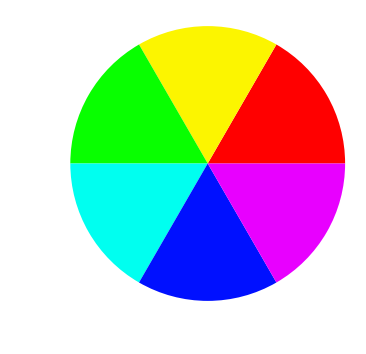

In [13]:
cm = matplotlib.cm.get_cmap('hsv')

patches = []
values = []

rotation = 0

ntheta = 6; dtheta = 360/ntheta;
nradius = 1; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta+1)
colors = [int(i) for i in colors]

saturations = np.linspace(0,.99,nradius)

for j, nr in enumerate(range(nradius,0,-1)):  # See!  Outside to Inside
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
    
        rgb = cm(colors[nt])
        hsv = list(colorsys.rgb_to_hsv(*rgb[0:3]))
        hsv[1] = hsv[1]-saturations[j]
        rgb = colorsys.hsv_to_rgb(*hsv)
        
        values.append(tuple(np.clip(rgb,0,1)))
        wedge = mpatches.Wedge(0,end_r, start_t+rotation, end_t+rotation)
        patches.append(wedge)
        
collection = PatchCollection(patches,linewidth=0.0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

In [12]:
### Now, how to assign voxel RGBs to an HSV bin? Simply convert to HSV?
# yes lets do that, then assign to a hue bin

#####################
### Make Hue Bins ###
#####################

hue_bin_centers = [i/255 for i in colors]
bin_width = hue_bin_centers[1] - hue_bin_centers[0]

hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
hue_bin_ends = [i+bin_width/2 for i in hue_bin_centers]
# deal with wrapping red around zero
hue_bin_starts[0] = 0
hue_bin_ends[-1] = 1

# Then, will need to combine first and last bins into red, since currently they are only half of red

In [14]:
### Get Hue Bin Counts ###

bin_cnts = []
for bn in range(len(hue_bin_starts)):
    bin_cnt = np.where(np.logical_and(hue_bin_starts[bn]<=hsv_vol[:,0], hsv_vol[:,0]<hue_bin_ends[bn]))[0].shape[0]
    bin_cnts.append(bin_cnt)
bin_cnts_max = np.max(bin_cnts)
bin_cnts_norm = [i/bin_cnts_max for i in bin_cnts]

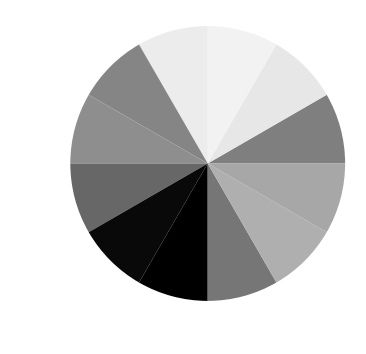

In [15]:
cm = matplotlib.cm.get_cmap('Greys')

patches = []
values = []

ntheta = 12; dtheta = 360/ntheta;
nradius = 1; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta+1)
colors = [int(i) for i in colors]

saturations = np.linspace(0,.99,nradius)

for j, nr in enumerate(range(nradius,0,-1)):  # See!  Outside to Inside
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
        
        values.append(cm(bin_cnts_norm[nt]))
        wedge = mpatches.Wedge(0,end_r, start_t, end_t)
        patches.append(wedge)
        
collection = PatchCollection(patches,linewidth=0.0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

In [23]:
####################
### MAKE HSV VOL ###
####################

vol_flat = np.reshape(vol, (-1,3))
vol_flat = np.clip(vol_flat,0,1) # there are some negative corrs. remove these.
hsv_vol = []
for i in range(vol_flat.shape[0]):
    if np.sum(vol_flat[i]) != 0: # exclude black pixels (0,0,0)
        hsv_vol.append(colorsys.rgb_to_hsv(*vol_flat[i]))
hsv_vol = np.asarray(hsv_vol)

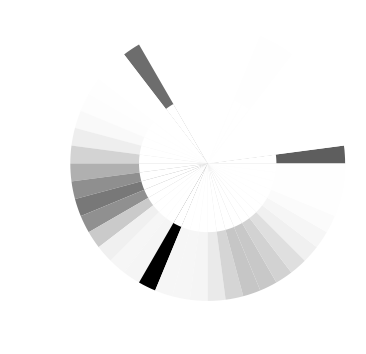

In [61]:
cm = matplotlib.cm.get_cmap('Greys')

patches = []
values = []

ntheta = 48; dtheta = 360/ntheta;
nradius = 2; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta+1)
colors = [int(i) for i in colors]

saturations = np.linspace(0,1,nradius)

#####################
### Make Hue Bins ###
#####################

hue_bin_centers = [i/255 for i in colors]
bin_width = hue_bin_centers[1] - hue_bin_centers[0]

hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
hue_bin_ends = [i+bin_width/2 for i in hue_bin_centers]
# deal with wrapping red around zero
hue_bin_starts[0] = 0
hue_bin_ends[-1] = 1

##########################
### Get Hue Bin Counts ###
##########################

bin_cnts = []
for bn in range(len(hue_bin_starts)):
    bin_cnt = np.where(np.logical_and(hue_bin_starts[bn]<=hsv_vol[:,0], hsv_vol[:,0]<hue_bin_ends[bn]))[0].shape[0]
    bin_cnts.append(bin_cnt)
bin_cnts_max = np.max(bin_cnts)/5 ### ADJUST THIS TO CLIP
bin_cnts_norm = [i/bin_cnts_max for i in bin_cnts]

for nr in range(nradius,0,-1):
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
        if nr == 1:
            values.append(cm(0))
        else:
            values.append(cm(bin_cnts_norm[nt]))
        wedge = mpatches.Wedge(0,end_r, start_t, end_t)
        patches.append(wedge)
        
collection = PatchCollection(patches,linewidth=0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

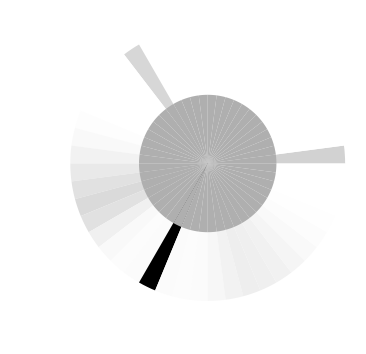

In [68]:
cm = matplotlib.cm.get_cmap('Greys')

patches = []
values = []

ntheta = 48; dtheta = 360/ntheta;
nradius = 2; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta+1)
colors = [int(i) for i in colors]

saturations = np.linspace(0,1,nradius)

#####################
### Make Hue Bins ###
#####################

hue_bin_centers = [i/255 for i in colors]
bin_width = hue_bin_centers[1] - hue_bin_centers[0]

hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
hue_bin_ends = [i+bin_width/2 for i in hue_bin_centers]
# deal with wrapping red around zero
hue_bin_starts[0] = 0
hue_bin_ends[-1] = 1

##########################
### Get Hue Bin Counts ###
##########################

bin_cnts = []
for bn in range(len(hue_bin_starts)):
    #excluding low sat voxels
    bin_cnt = np.where(np.logical_and(hue_bin_starts[bn]<=hsv_vol[:,0], hsv_vol[:,0]<hue_bin_ends[bn], hsv_vol[:,1]>.9))[0].shape[0]
    bin_cnts.append(bin_cnt)
bin_cnts_max = np.max(bin_cnts)/2 ### ADJUST THIS TO CLIP
bin_cnts_norm = [i/bin_cnts_max for i in bin_cnts]

### count low sat voxels
low_sat_cnt = np.where(hsv_vol[:,1]<.9)[0].shape[0]

for nr in range(nradius,0,-1):
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
        if nr == 1:
            values.append(cm(low_sat_cnt/bin_cnts_max))
        else:
            values.append(cm(bin_cnts_norm[nt]))
        wedge = mpatches.Wedge(0,end_r, start_t, end_t)
        patches.append(wedge)
        
collection = PatchCollection(patches,linewidth=0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

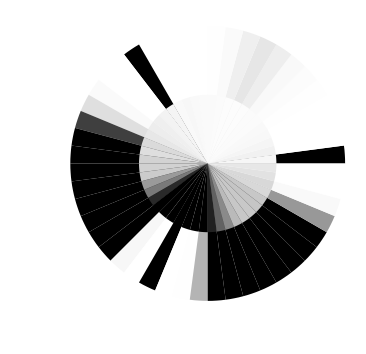

In [7]:
cm = matplotlib.cm.get_cmap('Greys')

patches = []
values = []

ntheta = 48; dtheta = 360/ntheta;
nradius = 2; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta+1)
colors = [int(i) for i in colors]

saturations = np.linspace(0,1,nradius)

#####################
### Make Hue Bins ###
#####################

hue_bin_centers = [i/255 for i in colors]
bin_width = hue_bin_centers[1] - hue_bin_centers[0]

hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
hue_bin_ends = [i+bin_width/2 for i in hue_bin_centers]
# deal with wrapping red around zero
hue_bin_starts[0] = 0
hue_bin_ends[-1] = 1

##########################
### Get Hue Bin Counts ###
##########################

bin_cnts_high = []
bin_cnts_low = []
for bn in range(len(hue_bin_starts)):
    hue_bin = np.where(np.logical_and(hue_bin_starts[bn]<=hsv_vol[:,0], hsv_vol[:,0]<hue_bin_ends[bn]))[0]
    
    # high sat voxels
    sat_bin = np.where(hsv_vol[:,1]>.9)[0]
    bin_cnts_high.append(len(set(hue_bin) & set(sat_bin)))
    
    # low sat voxels
    sat_bin = np.where(hsv_vol[:,1]<.9)[0]
    bin_cnts_low.append(len(set(hue_bin) & set(sat_bin)))
    
bin_cnts_max = np.max(bin_cnts_high)/100 ### ADJUST THIS TO CLIP
bin_cnts_high_norm = [i/bin_cnts_max for i in bin_cnts_high]
bin_cnts_low_norm = [i/bin_cnts_max for i in bin_cnts_low]


### count low sat voxels
low_sat_cnt = np.where(hsv_vol[:,1]<.9)[0].shape[0]

for nr in range(nradius,0,-1):
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
        if nr == 1:
            values.append(cm(bin_cnts_low_norm[nt]))
        else:
            values.append(cm(bin_cnts_high_norm[nt]))
        wedge = mpatches.Wedge(0,end_r, start_t, end_t)
        patches.append(wedge)
        
collection = PatchCollection(patches,linewidth=0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

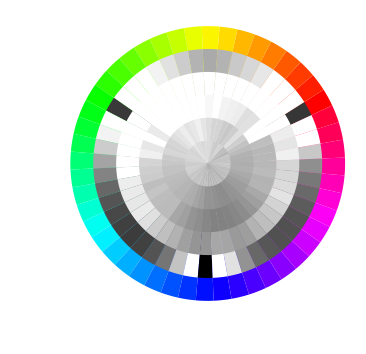

In [22]:
cm_grey = matplotlib.cm.get_cmap('Greys')
cm_hsv = matplotlib.cm.get_cmap('hsv')


patches = []
values = []

rotation = 25

ntheta = 48; dtheta = 360/ntheta;
nradius = 6; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta+1)
colors = [int(i) for i in colors]

saturations = np.linspace(0,1,nradius)

#####################
### Make Hue Bins ###
#####################

hue_bin_centers = [i/255 for i in colors]
bin_width = hue_bin_centers[1] - hue_bin_centers[0]

hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
hue_bin_ends = [i+bin_width/2 for i in hue_bin_centers]
# deal with wrapping red around zero
hue_bin_starts[0] = 0
hue_bin_ends[-1] = 1

#####################
### Make Sat Bins ###
#####################
sat_bin_starts = [.8,.6,.4,.2,0]
sat_bin_ends = [1,.8,.6,.4,.2]

##############################
### Get Hue/Sat Bin Counts ###
##############################

bin_cnts = []

for sat_bn in range(len(sat_bin_starts)):
    sat_bin = np.where(np.logical_and(sat_bin_starts[sat_bn]<hsv_vol[:,1],
                              hsv_vol[:,1]<=sat_bin_ends[sat_bn]))[0]
    for hue_bn in range(len(hue_bin_starts)):
        hue_bin = np.where(np.logical_and(hue_bin_starts[hue_bn]<=hsv_vol[:,0],
                                          hsv_vol[:,0]<hue_bin_ends[hue_bn]))[0]
        bin_cnts.append(len(set(hue_bin) & set(sat_bin)))

### Log transform ###
bin_cnts = np.log(bin_cnts)
bin_cnts[bin_cnts==-inf]=0
        
bin_cnts_max = np.max(bin_cnts) ### ADJUST THIS TO CLIP
bin_cnts_norm = [i/bin_cnts_max for i in bin_cnts]

cnt = 0
for nr in range(nradius,0,-1):
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
        if nr == 6:
            values.append(cm_hsv(int(nt*(255/ntheta))))
        else:
            values.append(cm_grey(bin_cnts_norm[cnt]))
            cnt+=1
        
        wedge = mpatches.Wedge(0,end_r, start_t+rotation, end_t+rotation)
        patches.append(wedge)
        
        
collection = PatchCollection(patches,linewidth=0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

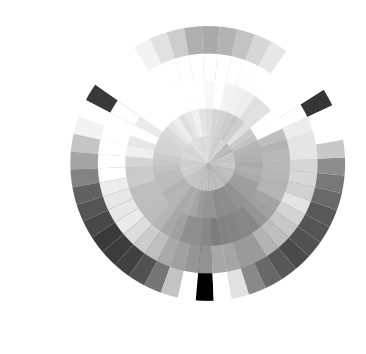

In [186]:
cm_grey = matplotlib.cm.get_cmap('Greys')
cm_hsv = matplotlib.cm.get_cmap('hsv')


patches = []
values = []

rotation = 25

ntheta = 48; dtheta = 360/ntheta;
nradius = 5; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta+1)
colors = [int(i) for i in colors]

saturations = np.linspace(0,1,nradius)

#####################
### Make Hue Bins ###
#####################

hue_bin_centers = [i/255 for i in colors]
bin_width = hue_bin_centers[1] - hue_bin_centers[0]

# hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
# hue_bin_ends = np.delete(hue_bin_starts,0).extend(1)
#hue_bin_ends = [i+bin_width/2 for i in hue_bin_centers]
# deal with wrapping red around zero
# hue_bin_starts[0] = 0
# hue_bin_ends[-1] = 1

hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
hue_bin_starts[0] = 0
hue_bin_ends = list(np.delete(hue_bin_starts,0))
hue_bin_ends.append(1)

#####################
### Make Sat Bins ###
#####################
sat_bin_starts = [.8,.6,.4,.2,0]
sat_bin_ends = [1,.8,.6,.4,.2]

##############################
### Get Hue/Sat Bin Counts ###
##############################

bin_cnts = []

for sat_bn in range(len(sat_bin_starts)):
    sat_bin = np.where(np.logical_and(sat_bin_starts[sat_bn]<hsv_vol[:,1],
                              hsv_vol[:,1]<=sat_bin_ends[sat_bn]))[0]
    for hue_bn in range(len(hue_bin_starts)):
        hue_bin = np.where(np.logical_and(hue_bin_starts[hue_bn]<=hsv_vol[:,0],
                                          hsv_vol[:,0]<hue_bin_ends[hue_bn]))[0]
        bin_cnts.append(len(set(hue_bin) & set(sat_bin)))

### Log transform ###
bin_cnts_log = np.log(bin_cnts)
bin_cnts_log[bin_cnts_log==-inf]=0
        
bin_cnts_max = np.max(bin_cnts_log) ### ADJUST THIS TO CLIP
bin_cnts_norm = [i/bin_cnts_max for i in bin_cnts_log]

cnt = 0
for nr in range(nradius,0,-1):
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
        if nr == 6:
            values.append(cm_hsv(int(nt*(255/ntheta))))
        else:
            values.append(cm_grey(bin_cnts_norm[cnt]))
            cnt+=1
        
        wedge = mpatches.Wedge(0,end_r, start_t+rotation, end_t+rotation)
        patches.append(wedge)
        
        
collection = PatchCollection(patches,linewidth=0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [188]:
red_cnt = bin_cnts[0]
green_cnt = bin_cnts[16]
blue_cnt = bin_cnts[32]

rg_cnt = np.sum(bin_cnts[1:16])
gb_cnt = np.sum(bin_cnts[17:32])
br_cnt = np.sum(bin_cnts[33:48])
rgb_cnt = np.sum(bin_cnts[49:])

In [190]:
np.sum(bin_cnts)

179994

In [189]:
print(
    red_cnt, 
    green_cnt,
    blue_cnt,
    rg_cnt,
    gb_cnt,
    br_cnt,
    rgb_cnt
     )

10457 9573 73455 463 44155 26263 15628


In [191]:
red_cnt+green_cnt+blue_cnt+rg_cnt+gb_cnt+br_cnt+rgb_cnt

179994

In [ ]:
# ok, how to best do this per atlas roi?
# 

In [118]:
len(to_keep)

179994

In [99]:
bin_cnts[16]

9573

In [94]:
len(bin_cnts), 48*5

(245, 240)

In [34]:
hue_bin_starts

[0,
 0.041176470588235294,
 0.12352941176470589,
 0.2058823529411765,
 0.292156862745098,
 0.37450980392156863,
 0.4568627450980392,
 0.5392156862745099,
 0.6254901960784314,
 0.707843137254902,
 0.7901960784313726,
 0.8725490196078431,
 0.9588235294117647]

In [172]:
hsv_vol.shape

(179994, 3)

In [74]:
sat_bin = np.where(np.logical_and(.8<hsv_vol[:,1],hsv_vol[:,1]<=1))

hue_bn=2
hue_bin = np.where(np.logical_and(hue_bin_starts[hue_bn]<=hsv_vol[:,0],
            hsv_vol[:,0]<hue_bin_ends[hue_bn]))

yellow_voxels = set(hue_bin[0]) & set(sat_bin[0])
yellow_voxels = list(yellow_voxels)
len(yellow_voxels)

387

In [75]:
### I think this one is right ###

empty = np.zeros(len(to_keep))
empty[yellow_voxels] = 1
full_vol = np.zeros(len(to_keep)+len(to_delete))
full_vol[to_keep] = empty
to_plot = np.reshape(full_vol, (49,128,256))

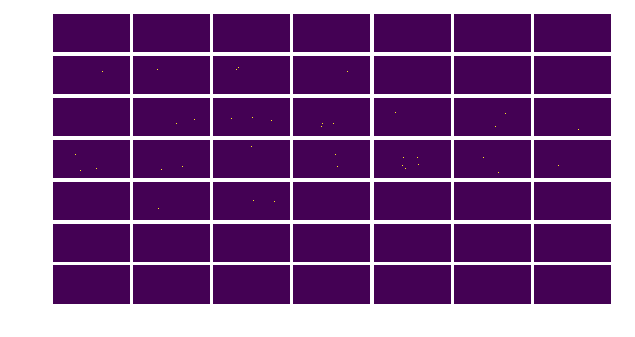

In [76]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(to_plot[i,:,:]);
    grid[i].axis('off')

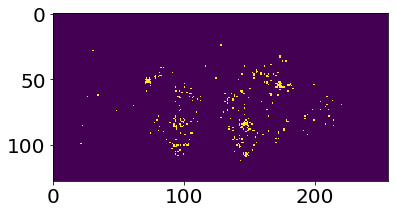

In [77]:
plt.imshow(np.max(to_plot,axis=0))

In [ ]:
to_keep = np.where(cluster_ids==clu)[0] #ie, yellow voxels
to_zero = [i for i in range(len(cluster_ids)) if i not in to_keep]

cluster_ids_for_singles[to_zero] = np.nan

add_deleted_voxels[to_replace] = cluster_ids_for_singles
add_deleted_voxels[to_delete] = np.nan

to_plot = np.reshape(add_deleted_voxels, (256,128,49))

In [ ]:
add_deleted_voxels = np.zeros(LR_mean_masked.shape[0]*LR_mean_masked.shape[1]*LR_mean_masked.shape[2])

to_replace = np.where(sums!=0)[0]

add_deleted_voxels[to_replace] = cluster_ids ### put signal here

add_deleted_voxels[to_delete] = np.nan

to_plot = np.reshape(add_deleted_voxels, LR_mean_masked.shape[:3])

In [36]:

test_vol = []
for i in range(vol_flat.shape[0]):
    if np.sum(vol_flat[i]) == 0:
        test_vol.append(0)
    if np.sum(vol_flat[i]) != 0: # black pixels (0,0,0)
        test_vol.append()
    
test_vol = np.asarray(test_vol)

387

In [47]:
# 1) insert yellow voxels into vector of zeros len(hsv_vol)
empty = np.zeros(hsv_vol.shape[0])
empty[yellow_voxels] = 1


# 2) need idx of removed 0,0,0s

In [173]:
max(yellow_voxels)

177694

In [176]:
256*128*49

1605632

In [175]:
empty = np.zeros(hsv_vol.shape[0])
empty[yellow_voxels] = 1
empty = np.reshape(empty,(49, 128, 256))

ValueError: cannot reshape array of size 179994 into shape (49,128,256)

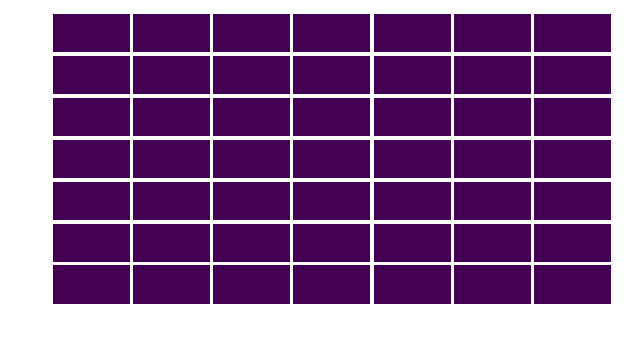

In [164]:
hsv_vol = []
for i in range(vol_flat.shape[0]):
    if np.sum(vol_flat[i]) != 0: # exclude black pixels (0,0,0)
        hsv_vol.append(yellow_voxels)
    else:
        hsv_vol.append((1,1,1))
hsv_vol = np.asarray(hsv_vol)



In [ ]:
test = np.zeros(vol_flat.shape[0])
test[np.where(hsv_vol[:,1]==0)[0]] = 1
test = np.reshape(test,(49, 128, 256))

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(test[i,:,:]);
    grid[i].axis('off')

In [154]:
len(test)

387

In [144]:
hue_bin_starts

[0,
 0.041176470588235294,
 0.12352941176470589,
 0.2058823529411765,
 0.292156862745098,
 0.37450980392156863,
 0.4568627450980392,
 0.5392156862745099,
 0.6254901960784314,
 0.707843137254902,
 0.7901960784313726,
 0.8725490196078431,
 0.9588235294117647]

In [135]:
for nt in range(0,ntheta):
    print(nt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [126]:
for nr in range(nradius,0,-1):
    print(nr)

5
4
3
2
1


In [112]:
np.log(10000)

9.210340371976184

(0, 2000)

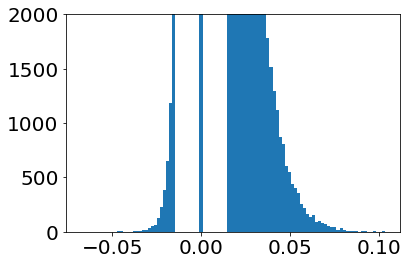

In [287]:
plt.hist(vol_flat[:,0],bins=100);
plt.ylim(0,2000)

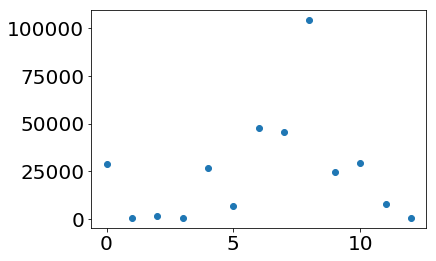

In [338]:
plt.plot(bin_cnts,'o')

In [294]:
hsv_vol.shape

(334067, 3)

Text(0.5, 1.0, 'val')

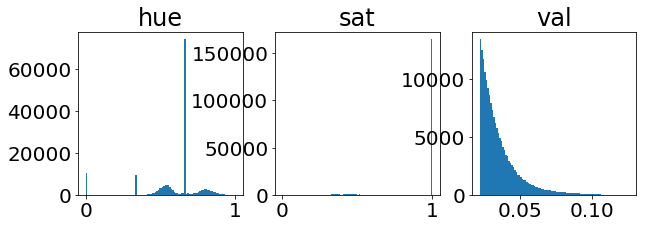

In [33]:
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.hist(hsv_vol[:,0],bins=100);
#plt.ylim(0,100000)
plt.title('hue')

plt.subplot(1,3,2)
plt.hist(hsv_vol[:,1],bins=100);
#plt.ylim(0,100000)
plt.title('sat')

plt.subplot(1,3,3)
plt.hist(hsv_vol[:,2],bins=100);
#plt.ylim(0,100000)
plt.title('val')

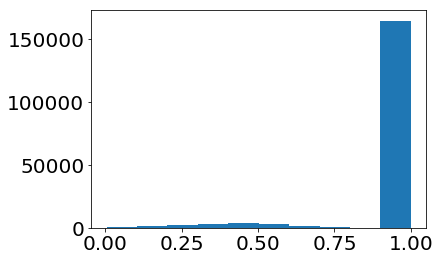

In [35]:
plt.hist(hsv_vol[:,1],bins=10);

In [302]:
test.shape

(49, 128, 256)

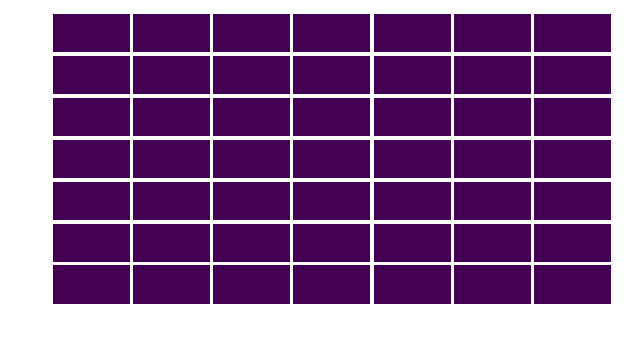

In [165]:
vol_flat = np.reshape(vol, (-1,3))
vol_flat = np.clip(vol_flat,0,1)
hsv_vol = []
for i in range(vol_flat.shape[0]):
    if np.sum(vol_flat[i]) != 0: # exclude black pixels (0,0,0)
        hsv_vol.append(colorsys.rgb_to_hsv(*vol_flat[i]))
    else:
        hsv_vol.append((1,1,1))
hsv_vol = np.asarray(hsv_vol)

test = np.zeros(vol_flat.shape[0])
test[np.where(hsv_vol[:,1]==0)[0]] = 1
test = np.reshape(test,(49, 128, 256))

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(test[i,:,:]);
    grid[i].axis('off')

In [308]:
hsv_vol[np.where(hsv_vol[:,1]==0),:]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

(0, 10000)

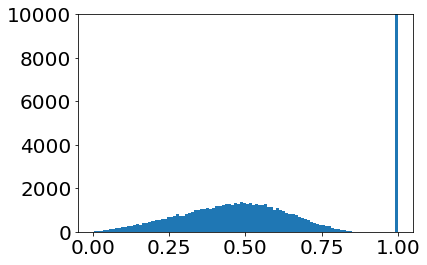

In [319]:
plt.hist(hsv_vol[:,1],bins=100);
plt.ylim(0,10000)

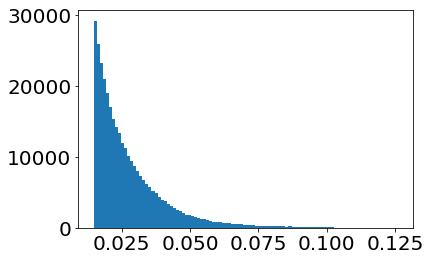

In [312]:
plt.hist(hsv_vol[:,2],bins=100);

In [281]:
colorsys.rgb_to_hsv(.1,.2,.1)

(0.3333333333333333, 0.5, 0.2)

In [279]:
hsv_vol[:100,1]

array([       inf, 1.        , 1.        , 1.        , 1.        ,
       1.        ,        inf, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ,        inf,        inf,
              inf, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 2.16883247,        inf,
              inf,        inf,        inf, 1.        , 1.        ,
              inf, 1.        ,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf, 1.        ,        inf,
              inf,        inf, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.95959887,        

In [277]:
np.nan_to_num(hsv_vol[:,1])

array([1.79769313e+308, 1.00000000e+000, 1.00000000e+000, ...,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000])

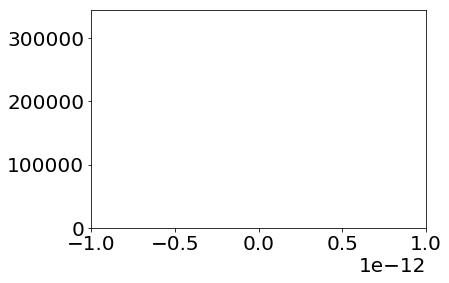

In [267]:
plt.hist(np.nan_to_num(hsv_vol[:,1]),bins=100);

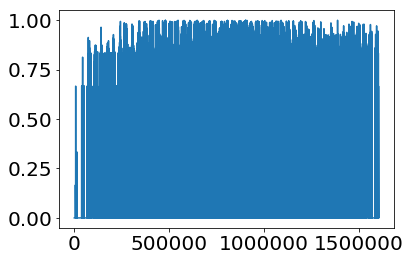

In [250]:
plt.plot(hsv_vol[:,0])

In [206]:
range(0,ntheta)

range(0, 12)

In [191]:
colors

[0, 23, 46, 69, 92, 115, 139, 162, 185, 208, 231, 255]

In [190]:
for nt in range(0,ntheta):
    print(nt)

0
1
2
3
4
5
6
7
8
9
10
11


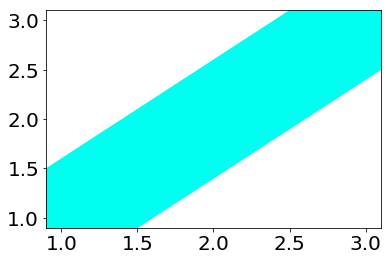

In [112]:
plt.plot([1,2,3],[1,2,3],color=cm(127),lw=100)

In [118]:
cm(127)[0:3]

(0.0, 1.0, 0.9415415212269964)

In [158]:
hsv = list(colorsys.rgb_to_hsv(*cm(127)[0:3]))
hsv[1] = hsv[1]/28
test = colorsys.hsv_to_rgb(*hsv)

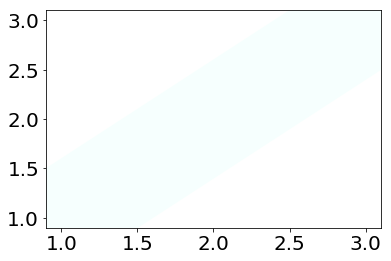

In [159]:
plt.plot([1,2,3],[1,2,3],color=test,lw=100)

In [126]:
hsv[1]/2

0.5

In [124]:
test

(0.0, 1.0, 0.9415415212269966)

In [82]:
cm(23.456)

(1.0, 0.0, 0.09375, 1.0)

In [78]:
cm(100)

(0.0, 1.0, 0.3161771885991356, 1.0)

In [75]:
colors

array([  0.        ,  23.18181818,  46.36363636,  69.54545455,
        92.72727273, 115.90909091, 139.09090909, 162.27272727,
       185.45454545, 208.63636364, 231.81818182, 255.        ])

In [45]:
cm = matplotlib.cm.get_cmap('hsv')

In [58]:
cm(255)

(1.0, 0.0, 0.09375, 1.0)

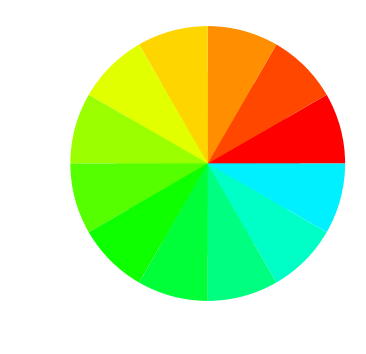

In [27]:
fig.add_subplot()